# Machine Learning Foundation
## Dimensionality Reduction

### Introduction
We will be using customer data from a Portuguese wholesale distributor for clustering. This data is called Wholesale_Customers_data

In [1]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, os
import warnings
warnings.filterwarnings('ignore')
os.chdir('data')
from colorsetup import colors, palette
sns.set_palette(palette)

### Part 1


In [16]:
data=pd.read_csv('Wholesale_Customers_Data.csv')

In [5]:
data.shape

(440, 8)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [8]:
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [17]:
data=data.drop({'Channel','Region'}, axis=1)

In [18]:
data.dtypes

Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object

In [19]:
data_orig = data.copy()

In [20]:
# convert to floats
for col in data.columns:
    data[col]=data[col].astype(np.float32)

In [21]:
data.dtypes

Fresh               float32
Milk                float32
Grocery             float32
Frozen              float32
Detergents_Paper    float32
Delicassen          float32
dtype: object

### Part 2

In [30]:
corr_mat=data.corr()

In [33]:
for i in range(len(data.columns)):
    corr_mat.iloc[i,i]=0.0

In [34]:
corr_mat

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Fresh,0.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.100510,0.000000,0.728335,0.123994,0.661816,0.406368
Grocery,-0.011854,0.728335,0.000000,-0.040193,0.924641,0.205497
Frozen,0.345881,0.123994,-0.040193,0.000000,-0.131525,0.390947
Detergents_Paper,-0.101953,0.661816,0.924641,-0.131525,0.000000,0.069291
Delicassen,0.244690,0.406368,0.205497,0.390947,0.069291,0.000000


In [36]:
corr_mat.abs().idxmax()

Fresh                         Frozen
Milk                         Grocery
Grocery             Detergents_Paper
Frozen                    Delicassen
Detergents_Paper             Grocery
Delicassen                      Milk
dtype: object

In [37]:
log_columns = data.skew().sort_values(ascending=False)
log_columns = log_columns.loc[log_columns > 0.75]

log_columns

Delicassen          11.151587
Frozen               5.907986
Milk                 4.053755
Detergents_Paper     3.631851
Grocery              3.587429
Fresh                2.561323
dtype: float32

In [38]:
# The log transformations
for col in log_columns.index:
    data[col] = np.log1p(data[col])

In [39]:
from sklearn.preprocessing import MinMaxScaler

mms=MinMaxScaler()

for col in data.columns:
    data[col]=mms.fit_transform(data[[col]]).squeeze()

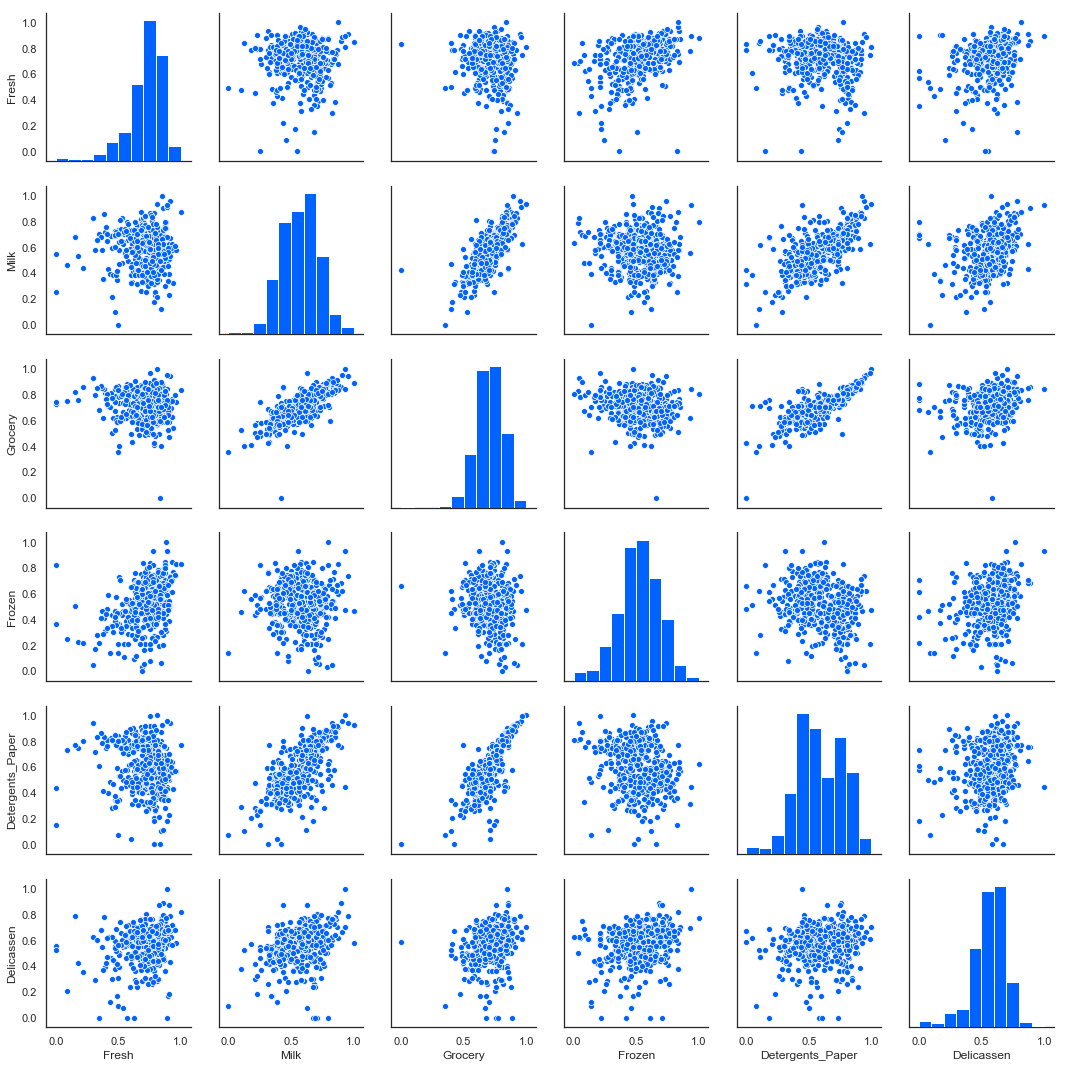

In [40]:
sns.set_context('notebook')
sns.set_style('white')
sns.pairplot(data);

### Part 3: Pipeline

In [44]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

# The custom Numpy log transformer
log_transformer=FunctionTransformer(np.log1p)

# The Pipeline
estimators=[('log1p', log_transformer), ('minmaxscaler', MinMaxScaler())]
pipeline=Pipeline(estimators)

#Convert the original data
data_pipe=pipeline.fit_transform(data_orig)

In [45]:
np.allclose(data_pipe, data)

True

### Part 4: PCA

In [47]:
from sklearn.decomposition import PCA

pca_list=[]
feature_weight_list=list()

# Fit a range of PCA models
for num in range(1,6):
    # create and fit the model
    pca=PCA(n_components=num)
    pca.fit(data)
    
    # store the model and variance
    pca_list.append(pd.Series({'n':num, 'model':pca,
                              'var': pca.explained_variance_ratio_.sum()}))
    
    # calculate and store feature importances
    abs_feature_values=np.abs(pca.components_).sum(axis=0)
    feature_weight_list.append(pd.DataFrame({'n':num,
                                             'features':data.columns,
                                             'values':abs_feature_values/abs_feature_values.sum()
    }))
    
pca_df = pd.concat(pca_list, axis=1).T.set_index('n')
pca_df

,model,var
n,,
1,"PCA(copy=True, iterated_power='auto', n_compon...",0.448011
2,"PCA(copy=True, iterated_power='auto', n_compon...",0.72099
3,"PCA(copy=True, iterated_power='auto', n_compon...",0.827534
4,"PCA(copy=True, iterated_power='auto', n_compon...",0.923045
5,"PCA(copy=True, iterated_power='auto', n_compon...",0.979574


In [48]:
features_df = (pd.concat(feature_weight_list)
               .pivot(index='n', columns='features', values='values'))

features_df

features,Delicassen,Detergents_Paper,Fresh,Frozen,Grocery,Milk
n,,,,,,
1,0.071668,0.335487,0.060620,0.095979,0.190236,0.246010
2,0.151237,0.177519,0.158168,0.222172,0.112032,0.178872
3,0.165518,0.145815,0.211434,0.268363,0.084903,0.123967
4,0.224259,0.149981,0.239527,0.214275,0.070971,0.100987
5,0.211840,0.182447,0.196382,0.178104,0.067338,0.163888


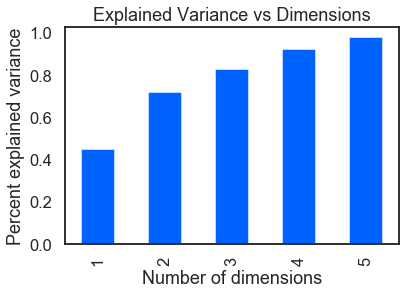

In [49]:
sns.set_context('talk')
ax = pca_df['var'].plot(kind='bar')

ax.set(xlabel='Number of dimensions',
       ylabel='Percent explained variance',
       title='Explained Variance vs Dimensions');

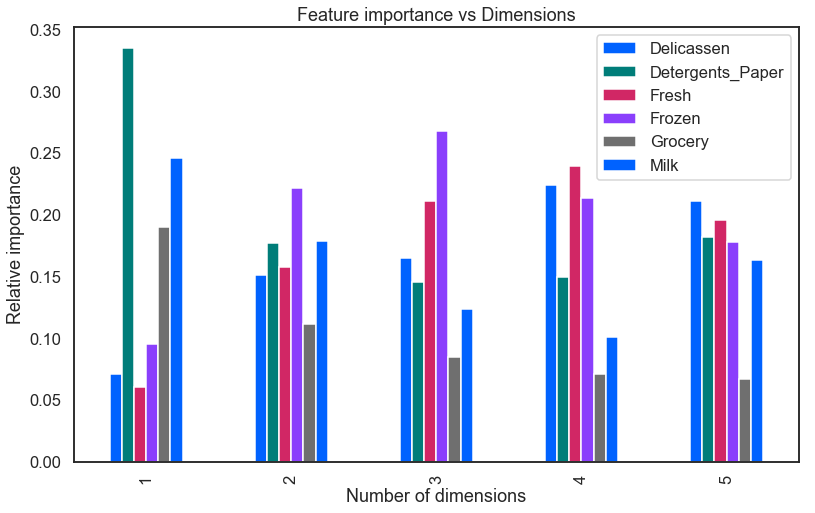

In [50]:
ax = features_df.plot(kind='bar', figsize=(13,8))
ax.legend(loc='upper right')
ax.set(xlabel='Number of dimensions',
       ylabel='Relative importance',
       title='Feature importance vs Dimensions');

### Part 5: Kernal PCA

In [53]:
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Custom scorer--use negative rmse of inverse transform
def scorer(pcamodel, X, y=None):

    try:
        X_val = X.values
    except:
        X_val = X
        
    # Calculate and inverse transform the data
    data_inv = pcamodel.fit(X_val).transform(X_val)
    data_inv = pcamodel.inverse_transform(data_inv)
    
    # The error calculation
    mse = mean_squared_error(data_inv.ravel(), X_val.ravel())
    
    # Larger values are better for scorers, so take negative value
    return -1.0 * mse

# The grid search parameters
param_grid = {'gamma':[0.001, 0.01, 0.05, 0.1, 0.5, 1.0],
              'n_components': [2, 3, 4]}

# The grid search
kernelPCA = GridSearchCV(KernelPCA(kernel='rbf', fit_inverse_transform=True),
                         param_grid=param_grid,
                         scoring=scorer,
                         n_jobs=-1)


kernelPCA = kernelPCA.fit(data)

kernelPCA.best_estimator_

KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=True, gamma=0.5, kernel='rbf',
     kernel_params=None, max_iter=None, n_components=4, n_jobs=None,
     random_state=None, remove_zero_eig=False, tol=0)

### Part 6

In [54]:
data = pd.read_csv('Human_Activity_Recognition_Using_Smartphones_Data.csv', sep=',')

In [55]:
data.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

In [56]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X = data.drop('Activity', axis=1)
y = data.Activity
sss = StratifiedShuffleSplit(n_splits=5, random_state=42)

def get_avg_score(n):
    pipe = [
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=n)),
        ('estimator', LogisticRegression(solver='liblinear'))
    ]
    pipe = Pipeline(pipe)
    scores = []
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        pipe.fit(X_train, y_train)
        scores.append(accuracy_score(y_test, pipe.predict(X_test)))
    return np.mean(scores)


ns = [10, 20, 50, 100, 150, 200, 300, 400]
score_list = [get_avg_score(n) for n in ns]

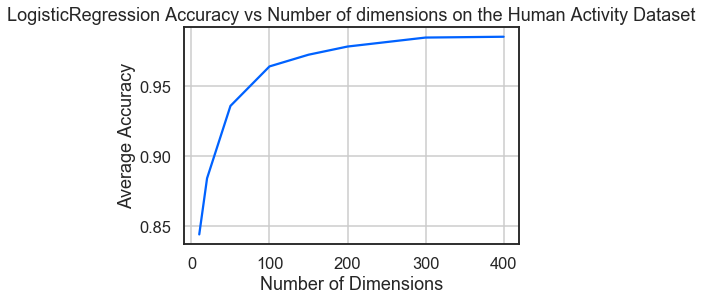

In [57]:
sns.set_context('talk')

ax = plt.axes()
ax.plot(ns, score_list)
ax.set(xlabel='Number of Dimensions',
       ylabel='Average Accuracy',
       title='LogisticRegression Accuracy vs Number of dimensions on the Human Activity Dataset')
ax.grid(True)